<img src='data/images/section-notebook-header.png' />

# Multi-Layer Perceptron (MLP)

A Multi-Layer Perceptron (MLP) is a type of artificial neural network that is widely used for various tasks, including classification, regression, and pattern recognition. An MLP consists of multiple layers of interconnected artificial neurons organized into an input layer, one or more hidden layers, and an output layer. Each neuron in a layer is connected to every neuron in the subsequent layer, forming a fully connected network. An MLP is a feedforward neural network, which means that the data is transmitted from the input layer to the output layer in the forward direction.

The neurons in an MLP are often modeled as perceptrons, which are basic computational units that take input values, apply weights to them, and pass the weighted sum through an activation function. The activation function introduces non-linearity into the network, allowing it to model complex relationships between inputs and outputs. For example, if the activation function is the Sigmoid function, the perceptron is identical to a Logistic Regression unit.

During training, an MLP learns the optimal weights for its connections by adjusting them based on the error between the predicted outputs and the desired outputs. This process, known as backpropagation, uses gradient descent optimization to iteratively update the weights and minimize the error. MLPs are considered shallow neural networks compared to deep neural networks, which have many more hidden layers. However, MLPs can still capture complex patterns and are effective for a wide range of tasks. They have been used successfully in various domains, including image recognition, natural language processing, and financial modeling.

**Important:** This notebook does not serve as a proper introductory tutorial into PyTorch, it only provides a minimal example for implementing a basic MLP text classifier, glossing over many details. If you are totally new to PyTorch, it's highly recommended to check out the tutorials on the [official PyTorch page](https://pytorch.org/tutorials/).

## Setting up the Notebook

### Import Required Packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm import tqdm

import matplotlib.pyplot as plt

We utilize PyTorch as our deep learning framework of choice by importing the `torch` package.

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

As usual, we rely on spaCy to perform basic text preprocessing and cleaning steps, mainly tokenization and lemmatization.

In [3]:
import spacy

# We use spaCy for preprocessing, but we only need the tokenizer and lemmatizer
# (for a large real-world dataset that would help with the performance)
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

### Checking/Setting the Computation Device

PyTorch allows to train neural networks on supported GPUs to significantly speed up the training process. If you have a support GPU, feel free to utilize it. However, for this notebook it's certainly not needed as our dataset is very small and our network model is very simple. In fact, the training might be faster on the CPU here since initializing memory on the GPU and moving the data to the GPU involves some overhead.

In [4]:
use_cuda = torch.cuda.is_available()

# Use this line below to enforce the use of the CPU (in case you don't have a supported GPU)
# With this small dataset and simple model you won't see a difference anyway
use_cuda = True

device = torch.device("cuda:0" if use_cuda else "cpu")

print("Available device: {}".format(device))

Available device: cuda:0


---

## Data Preparation

For this notebook, we use a simple dataset for sentiment classification. This dataset consists of 10,662 sentences, where 50% of the sentences are positive and 50% of the sentences are negative, split across 2 text files. Since PyTorch assumes that all class labels are integers between `0` and `C-1` -- where `C` is the number of classes -- we assume that negative sentences are labeled with `0` and positive sentences are labeled with `1`. The dictionary `label_map` reflects this idea.

### Loading Sentence/Label Pairs from File

In [5]:
file_names = [
    "data/corpora/sentence-polarity/sentence-polarity.pos",
    "data/corpora/sentence-polarity/sentence-polarity.neg"
]

label_map = {'neg': 0, 'pos': 1}

We generate our dataset by reading both text files containing the sentences. For each text file, we derive the class label from the file extension ("pos" or "neg"). When iterating through both files, we use spaCy to preprocess each sentence. More specifically, we

* Tokenize each sentence

* Lemmatize each token, and

* Filter out any non-words (e.g., numbers and punctuation marks) by check each token if `is_alpha==True`

Feel free to change the preprocessing steps to see if and how it might affect the results. For example, you can consider explicitly removing stopwords by additionally checking `is_stop==False` for each token. In the code cell below, we omit this step for two main reason:

* Since we use TF-IDF weights for the term-document matrix -- see below -- the weights for stopwords are expected to me very small

* Given the task of sentiment analysis, stopwords such as *"not"*, *"n't"*, *"never"*, etc. might be very useful, particularly if we consider features beyond unigrams (e.g., bigrams, trigrams, etc.)

But again, those are initial assumptions that may or may not hold.

In [6]:
sentences, labels = [], []

with tqdm(total=10662) as progress_bar:
    
    # Loop over all file names
    for file_name in file_names:

        # Get sentiment label from file name extensions
        label = label_map[file_name.split(".")[-1]]

        # Loop over each sentence (1 sentence per line)
        with open(file_name) as file:
            for line in file:
                sentence = line.strip()
                # Perform spaCy magic
                doc = nlp(sentence)
                sentence = ' '.join([ t.lemma_.lower() for t in doc if t.is_alpha == True ])
                sentences.append(sentence)
                # Add currently label to labels list
                labels.append(label)
                # Update progress bar
                progress_bar.update(1)
                
                
print("Total number of sentences: {}".format(len(sentences)))
print()
print(sentences[0])  # Print an example sentence

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10662/10662 [00:58<00:00, 180.82it/s]

Total number of sentences: 10662

the rock be destine to be the century new conan and that he go to make a splash even great than arnold schwarzenegger jean claud van damme or steven segal


### Create Training & Test Set

To evaluate any classifier, we need to split our dataset into a training and a test set. With the method `train_test_split()` this is very easy to do; this method also shuffles the dataset by default, which is important for this example, since the dataset file is ordered with all positive sentences coming first. In the example below, we set the size of the test set to 20%.

**Note:** The variable `sentences` containing all 10,662 from the input files lists first all 5,331 positive sentences and then all 5,331 negative sentences. Since we want to avoid that the test set but also training batches contain only sentences of the same label, it is strongly recommended to use shuffling!

In [7]:
# Split sentences and labels into training and test set with a test set size of 20%
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=0)

# We can directly convert the numerical class labels from lists to numpy arrays
y_train = np.asarray(labels_train, dtype=np.int8)
y_test = np.asarray(labels_test, dtype=np.int8)

print("Size of training set: {}".format(len(sentences_train)))
print("Size of test set: {}".format(len(sentences_test)))

Size of training set: 8529
Size of test set: 2133


### TF-IDF Feature Extraction

To serve as valid input for our network, we need to convert our sentences into document vectors. For this, we use as always a scikit-learn vectorizer. In the code cell below, you can try the TF-IDF vectorizer or the Count vectorizer. The final results will be more or less the same. Still, feel free to play with the choice of the vectorizer as well as with the different input parameters (e.g., `ngram_range` or `max_features`).

In [8]:
# Create Term-Document Matrix for different n-gram sizes
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000)
#vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=10000)

# Vectorize both training and test set
X_train = vectorizer.fit_transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

### Creating Tensors

Both `X_train` and `X_test` are now our matrices containing the document vectors of our training and test set. However, right now, `X_train` and `X_test` are sparse matrices, i.e., representations that only store the non-zero values. To further use this data with PyTorch, we have to perform 2 additional steps:

* Convert the sparse representation to a dense (i.e., full/normal) representation using `.todense()`; the output will be NumPy arrays

* Convert NumPy arrays to tensors. `Tensor` is the data object used by PyTorch; they look, feel, and handle basically the same as numpy arrays.

**Side note:** While PyTorch tensors "look" like NumPy arrays, under the hood, they additionally support all mechanisms and methods for deep learning tasks, offer native GPU acceleration and computational graph capabilities, and have a dedicated ecosystem for deep learning. NumPy is a general-purpose numerical computing library with a broader range of applications.

In [9]:
# The default Tensor stores float values
X_train = torch.Tensor(X_train.todense())
X_test = torch.Tensor(X_test.todense())

# Our labels are integers, hence we use LongTensor
# (that's required, otherwise we would get an error later)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([8529, 10000]) torch.Size([8529])
torch.Size([2133, 10000]) torch.Size([2133])


### Creating PyTorch Datasets

Training a neural network is usually not done computing the gradient w.r.t. the whole dataset as most of the time the dataset is way too large to fit into memory. It might also slow down training since the gradients w.r.t. the whole dataset can be very small (although this could be addressed by increasing the learning rate). In practice, the training is basically always done using batches, i.e., much smaller subsets of the data. While we can take `X_train` and `X_test` and implement our own loops to create batches, PyTorch comes with a series of convenient utility classes to simplify things.

The first utility class we use is the [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class; more specifically, since `Dataset` is in abstract class, we use the [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) class to wrap our tensors and make each sample retrievable by indexing the tensors along the first dimension. This will be used by the data loaders below.

In [10]:
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

### Creating Data Loaders

The [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class takes a `Dataset` object as input to handle to split the dataset into batches. As such, a data loader also has `batch_size` as an input parameter. In the following, we use a batch size of 64, although you can easily go higher since we are dealing with only single sentences which are unlikely to take up much memory.

In [11]:
batch_size = 64

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

We can use the data loaders to loop over all batches and use them for training and testing our model. The code cell below shows the general idea. The for loop would iterate all the batches as to include all the samples in the dataset. We therefore use a `break` to only look at the first batch and then stop the loop.

In [12]:
for X_batch, y_batch in loader_train:
    print("Shape of the input:  ", X_batch.shape)
    print("shape of the output: ", y_batch.shape)
    break

Shape of the input:   torch.Size([64, 10000])
shape of the output:  torch.Size([64])


Appreciate how much additional code we would have written if we had implemented this batching on our own. Well, it actually wouldn't be that much, but using these utility classes makes our code much cleaner and less prone to errors. These utility classes also allow to train models in a distributed setting; but this is not important at the moment. In short, always try to make use of existing utility classes and methods as much as possible! Only implement your own solutions if you really require special functionalities not supported by available classes and methods!

With respect to preparing our data, we are now ready to build and train a neural network model.

---

## Building the Model

In this notebook, we replicate the exact model architecture we used as an example on the lecture slides -- see the image below: We have 3 hidden layers and 2 outputs. Note that we could implement the model with just 1 output since we are trying to solve binary classification tasks. However, using 1 output and the Binary Cross Entropy Loss or using 2 outputs and using the Multiclass Cross Entropy Loss is completely equivalent. Hence, we simply implement to model exactly like visualized below:

<img src="data/images/mlp-example-network.png" width="90%">

Of course, our input layer doesn't have just 3 features but 10,000 (assuming that's the value of `max_features` of the vectorizer).

### Basic Implementation

The code cell below shows the most straightforward implementation of our network architecture. To make the model a bit flexible, we have the `vocab_size` (vocabulary size) as an input parameter. This means, any time we change the `max_features` parameter of the vectorizer, we define our model using this value. In this implementation, we use [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) (Rectified Linear Unit) as the activation function for each unit, which became often of the activation of choice. Still, fill free to try out other activation functions (e.g., [`nn.Tanh`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)). Of course, you can also mix it up across the different hidden layers.

For the activation function for the output layer we use [`nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) -- instead of [`nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax) -- which applies $\log(Softmax(x))$ to its input. This is very common in practice as it makes computation typically numerical stable as Softmax probabilities can be very small, particularly in case of many class labels. While we have only 2 classes here, and Softmax will probably do just fine, using the LogSoftmax is just a good practice. Of course, the outputs are no longer probabilities but log probabilities. This will affect the choice of the loss functions; see below.

In [13]:
class SimpleNet1(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        # Define 1st fully connected (i.e., linear) hidden layer
        self.fc1 = nn.Linear(self.vocab_size, 4)
        self.relu1 = nn.ReLU()
        # Define 2st fully connected (i.e., linear) hidden layer
        self.fc2 = nn.Linear(4, 3)
        self.relu2 = nn.ReLU()
        # Define 3st fully connected (i.e., linear) hidden layer
        self.fc3 = nn.Linear(3, 3)
        self.relu3 = nn.ReLU()
        # Define output layer (which is also a linear layer)
        self.out = nn.Linear(3, 2)        
        # Define log softmax layer
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.out(out)
        log_probs = self.log_softmax(out)
        return log_probs

To "visualize" the network, we can create and print an instance of the class `SimpleNet1`. The output should reflect the model architecture shown in the image above.

The command `.to(device)` "moves" the instance to the selected instance (e.g., the CPU or GPU). In general, both the model and the data need to reside on the same instance. So if the model will be on the GPU, we also need to move the data later to the GPU. Using consistently `.to(device)` on the model and the data (see below) ensures that there will be no mismatch.

In [14]:
# Create the model and move to device
classifier = SimpleNet1(X_train.shape[1]).to(device)

print(classifier)

SimpleNet1(
  (fc1): Linear(in_features=10000, out_features=4, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=4, out_features=3, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=3, out_features=3, bias=True)
  (relu3): ReLU()
  (out): Linear(in_features=3, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


### Modified Implementation

In the implementation above, we used the most basic approach by having 2 main parts:

* Defining all the layers in the `__init__()` method (i.e., the constructor)

* *"Push"* the data through all layers in the `forward()` method

While this is perfectly fine and for more complex models essentially required, here we can use some additional utility classes to simplify our code. Note how we push our data step-by-step (i.e., sequentially) through each layer. This means we can create a model component using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) that contains all our layers -- here, the model component is basically the complete model. Thus, in the `forward()` method, we only need to give the component the data, and the component will automatically push the data through all the layers.

In [15]:
class SimpleNet2(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        
        self.net = nn.Sequential(
            nn.Linear(self.vocab_size, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
            nn.ReLU(),
            nn.Linear(3, 3),
            nn.ReLU(),
            nn.Linear(3, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, X):
        log_probs = self.net(X)
        return log_probs

This is a neat way to save lines of code and make the implementation more readable and maintainable. Of course, if we create and print an instance of this class, the output should match the one frome `SimpleNet1` with respect to the core layers. Since we use `nn.Sequential` here, the output is not exactly the same, though.

In [16]:
# Create the model and move to device
classifier = SimpleNet2(X_train.shape[1]).to(device)

print(classifier)

SimpleNet2(
  (net): Sequential(
    (0): Linear(in_features=10000, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=3, bias=True)
    (5): ReLU()
    (6): Linear(in_features=3, out_features=2, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


There are several other ways to write the same model using different code structures. For example, PyTorch allows to define submodels and then combine them for the final/complete model. This is particularly useful for very large models that also might re-use different submodels -- you will later see this when we cover the Transformer model. For our very simple MLP model here, the definition of submodels would be just overkill and make the code actually unnecessarily complex.

---

## Training & Evaluating the Model

With the data prepared and the model architecture defined, we can now train and evaluate a model to build our sentiment classifier.

### Evaluation

The code cell below implements the method `evaluate()` to, well, evaluate our model. Apart from the model itself, the method also receives the data loader as input parameter. This allows us later to use both `loader_train` and `loader_test` to evaluate the training and test loss using the same method.

The method is very generic and is not specific to the dataset. It simply loops over all batches of the data loader, computes the log probabilities, uses these log probabilities to derive the predicted class labels, and compares the predictions with the ground truth to return the f1 score. This means, this method could be used "as is" or easily be adopted for all kinds of classifications tasks (incl. tasks with more than 2 classes).

In [17]:
def evaluate(model, loader):

    # Set model to "eval" mode (not needed here, but a good practice)
    model.eval()

    # Collect predictions and ground truth for all samples across all batches
    y_pred, y_test = [], []

    with tqdm(total=len(loader)) as pbar:
        
        # Loop over each batch in the data loader
        for X_batch, y_batch in loader:

            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Push batch through network to get log probabilities for each sample in batch
            log_probs = model(X_batch)                
            
            # The predicted labels are the index of the higest log probability (for each sample)
            y_batch_pred = torch.argmax(log_probs, dim=1)

            # Add predictions and ground truth for current batch
            y_test += list(y_batch.detach().cpu().numpy())
            y_pred += list(y_batch_pred.detach().cpu().numpy())

            pbar.update(1)

    # Set model to "train" mode (not needed here, but a good practice)
    model.train()            
            
    # Return the f1 score as the output result
    return metrics.f1_score(y_test, y_pred, average='micro')

For a quick test, let's evaluate the newly created model. Of course, we didn't train our model, but it will still make predictions based on the initial weights.

In [18]:
print(evaluate(classifier, loader_test))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.49it/s]

0.5208626347866854


**Side note:** When looking at the method above, you might have noticed that we never explicitly call the `forward()` method of our model. Instead, we have the line `log_probs = model(X_batch)`. Note that this is exactly the same as calling `log_probs = model.forward(X_batch)`. Python allows to define a method `__call__` for a class which makes an instance of a model behave like a function. In PyTorch, the `__call__` method simply calls the `forward()` methods. This allows us to drop the `forward` name, and is de-facto standard in PyTorch code.

### Training (and evaluation after each epoch)

Similar to the method `evaluate()` we also implement a method `train()` to wrap all the required steps training. This has the advantage that we can simply call `train()` multiple times to proceed with the training. Apart from the model, this method has the following input parameters:

* `loader_train` and `loader_test`: this allows us to compute the f1 score over the training data an the test data after each epoch; we can later visualize the changes in the f1 scores

* `optimizer`: the optimizer specifies how the computed gradients are used to updates the weights; in the lecture, we only covered the basic Stochastic Gradient Descent, but there are much more efficient alternatives available

* `criterion`: this is the loss function; "criterion" is just very common terminology in the PyTorch documentation and tutorials

* `num_epochs`: the number of epochs -- i.e., the number of times we want train over all samples in our dataset

The heart of the method is the snippet described as PyTorch Magic. It consists of the following 3 lines of code

* `optimizer.zero_grad()`: After each training step for a batch, set the gradients back to zero for the next batch

* `loss.backward()`: Calculate all gradients using backpropagation

* `optimizer.step()`: Update all weights using the gradients and the method of the specific optimizer

In [19]:
def train(model, loader_train, loader_test, optimizer, criterion, num_epochs):

    losses, f1_train, f1_test = [], [], []
    
    # Set model to "train" mode (not needed here, but a good practice)
    model.train()

    # Run all epochs
    for epoch in range(1, num_epochs+1):

        # Initialize epoch loss (cummulative loss fo all batchs)
        epoch_loss = 0.0

        with tqdm(total=len(loader_train)) as pbar:

            # Loop over each batch in the data loader
            for X_batch, y_batch in loader_train:

                # Move data to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Push batch through network to get log probabilities for each sample in batch
                log_probs = classifier(X_batch)                

                # Calculate loss
                loss = criterion(log_probs, y_batch)

                ### PyTorch Magic! ###
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Keep track of overall epoch loss
                epoch_loss += loss.item()

                pbar.update(1)
        
        # Keep track of all epoch losses
        losses.append(epoch_loss)
        
        # Compute f1 score for both TRAINING and TEST data
        f1_tr = evaluate(model, loader_train)
        f1_te = evaluate(model, loader_test)
        f1_train.append(f1_tr)
        f1_test.append(f1_te)

        print("Loss:\t{:.3f}, f1 train: {:.3f}, f1 test: {:.3f} (epoch {})".format(epoch_loss, f1_tr, f1_te, epoch))
     
    # Return all losses and f1 scores (all = for each epoch)
    return losses, f1_train, f1_test        

Before we can actually train the model, we need to instantiate the `criterion` (i.e., the loss function) and the `optimizer`. Since out model returns log probabilities, we need to use the [`nn.NLLLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), i.e., the Negative Log Likelihood Loss. This is basically the same as the Multiclass Cross Entropy Loss but using log probabilities instead of probabilities.

For the optimizer, we pick the widely used [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer. It stands for "Adaptive Moment Estimation" and it maintains an adaptive learning rate for each parameter in the neural network. It computes individual learning rates based on estimates of the first and second moments of the gradients. This adaptive learning rate enables the optimizer to converge quickly and effectively navigate complex optimization landscapes. A deeper technical discussion about Adam is way beyond our scope here. In essence, however, it performs the same task as Gradient Descent: minimizing the loss by adjusting the learnable parameters based on their gradients.

In [20]:
# Create the model and movie to device
classifier = SimpleNet2(X_train.shape[1]).to(device)

# Define loss function
criterion = nn.NLLLoss()

# Define optimizer (you can try, but the basic (Stochastic) Gradient Descent is actually not great)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
# Feel free to try SGD to see how poorly it performs compared to Adam
#optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001)

Now we finally have everything in place to train the model. For this, we now only need to call the `train()` in the code cell below. Note that you can run the code cell below multiple times to continue the training for further 10 epochs. Each epoch will print 3 progress bars:

* training over training set

* evaluating over training set

* evaluating over test set

After each epoch, a print statement will show the current loss as well as the latest f1 scores for the training and test set.

In [21]:
num_epochs = 10

losses, f1_train, f1_test = train(classifier, loader_train, loader_test, optimizer, criterion, num_epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 424.96it/s]


Loss:	92.903, f1 train: 0.505, f1 test: 0.479 (epoch 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 429.19it/s]


Loss:	92.148, f1 train: 0.495, f1 test: 0.521 (epoch 2)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 426.43it/s]


Loss:	81.594, f1 train: 0.854, f1 test: 0.755 (epoch 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 423.76it/s]


Loss:	60.356, f1 train: 0.919, f1 test: 0.777 (epoch 4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 427.20it/s]


Loss:	45.781, f1 train: 0.944, f1 test: 0.773 (epoch 5)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 428.46it/s]


Loss:	36.016, f1 train: 0.960, f1 test: 0.776 (epoch 6)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 420.16it/s]


Loss:	29.071, f1 train: 0.971, f1 test: 0.773 (epoch 7)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 437.12it/s]


Loss:	23.976, f1 train: 0.978, f1 test: 0.767 (epoch 8)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 424.68it/s]


Loss:	20.008, f1 train: 0.983, f1 test: 0.766 (epoch 9)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 430.06it/s]

Loss:	16.984, f1 train: 0.985, f1 test: 0.762 (epoch 10)


### Plotting the Results

Since the method `train()` returns the losses and f1 scores for each epoch, we can use this data to visualize how the loss and the f1 scores change over time, i.e., after each epoch. The code cell below creates the corresponding plot.

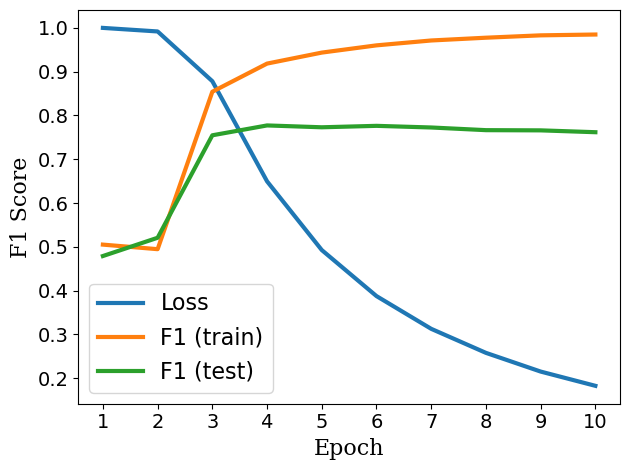

In [22]:
x = list(range(1, len(losses)+1))

# Convert losses to numpy array
losses = np.asarray(losses)
# Normalize losses so they match the scale in the plot (we are only interested in the trend of the losses!)
losses = losses/np.max(losses)

plt.figure()

plt.plot(x, losses, lw=3)
plt.plot(x, f1_train, lw=3)
plt.plot(x, f1_test, lw=3)

font_axes = {'family':'serif','color':'black','size':16}

plt.gca().set_xticks(x)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.legend(['Loss', 'F1 (train)', 'F1 (test)'], loc='lower left', fontsize=16)
plt.tight_layout()
plt.show()

From the plot, we can observe several things

* The loss goes down! This essentially means that our model is learning. This can be very useful as an incorrectly implemented model may not throw an error but not train properly (i.e., the loss not going down). So it's a good sanity check when implementing and using a new model.

* The f1 score over the training data reaches 1.0 (at least after more epoch). This means that the model learns to correctly predict the label for all training samples. Of course, this is not what we are interested in but (a) again tells us that the model is generally learning, and (b) this might give us insights that our model is overfitting.

* The f1 score over the test data almost plateaus after Epochs 3-4 and even tend to decrease a bit later. This indicates that the model starts to overfit after Epoch 6

**Important:** This plot showing the trends for the loss and f1 scores (or other metrics) can look very different depending on the dataset, the network architecture, and the hyperparameters. While in this simple example all trends seem to smoothly converge, this is not the case in general. For example, the f1 score for the test data might see a much steeper drop after peaking, which would even more clearly indicate the model is starting to overfit.

---

## Summary

In this notebook, we built our first text classifier using PyTorch. In more detail, we trained and evaluated a Multi-Layer Perceptron to build a classifier for sentiment analysis. Building and training more complex architecture might require more code, but most of the essential steps have been covered here. For example, we already made use of important utility classes such as `Dataset` and `DataLoader` that help us prepare our datasets for the training using batches. Also method 'train()' shows the general blueprint of the train loop in PyTorch: loop over each batch, compute model output, compute loss and perform the "PyTorch Magic" (i.e.: compute gradients using backpropagation and all update trainable parameters).

Appreciate how PyTorch hides all the nitty-gritty details of the training process, most importantly the computation of all gradients and the updates of the weights. While implementing backpropagation from scratch is not too difficult for simple MLP architectures, for more advanced architectures covered later this would become quite demanding. MLPs for simple text classification can provide decent results, especially for tasks with moderate-sized datasets and relatively simple classification requirements. However, for more complex text classification tasks, recurrent neural networks (RNNs), convolutional neural networks (CNNs), or transformer-based models like BERT may be more suitable and can achieve state-of-the-art performance.

**Side note:** The most obvious limitation of using an MLP architecture is that it does not support sequential data but treats text documents as a "Bag of Words" (here with TF-IDF weights). We only preserve some information about the word order if we consider bigrams, trigrams, and so on when vectorizing our documents. To really utilize the sequential nature of text data we have to rely on more sophisticated architectures such as RNNs and Transformers. CNNs are also rather limited in this regard as they also only consider word order on a more local level but not fully across complete sentences or documents.